<font size="+3"><strong>JNB4 Predicting Price with Size, Location, and Neighborhood</strong></font>

In [88]:
import pandas as pd
import numpy as np
import seaborn as sns

from glob import glob
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline

# Prepare Data

## Import

In [89]:
def wrangle(filepath):
    # Read CSV file
    df = pd.read_csv(filepath)

    # Subset data: Apartments in "Capital Federal", less than 400,000
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 400_000
    df = df[mask_ba & mask_apt & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)

    # Get place name
    df["neighborhood"] = df["place_with_parent_names"].str.split("|", expand=True)[3]
    df.drop(columns="place_with_parent_names", inplace=True)
    
    # Drop features with high null counts
    df.drop(columns=["floor", "expenses"], inplace=True)
    
    # Drop low and high cardinality categorical vaiables
    df.drop(columns=["operation", "property_type", "currency", "properati_url"], inplace=True)
    
    # Drop leaky columns
    df.drop(columns=['price','price_aprox_local_currency','price_per_m2','price_usd_per_m2'], inplace=True)
        
    # Drop columns with multicolleniarity
    df.drop(columns=["surface_total_in_m2", "rooms"], inplace=True)
    
    return df

In [90]:
files = glob("data/argentina_realestate_*.csv")
files

['data/argentina_realestate_3.csv',
 'data/argentina_realestate_2.csv',
 'data/argentina_realestate_1.csv',
 'data/argentina_realestate_5.csv',
 'data/argentina_realestate_4.csv']

In [91]:
frames = [wrangle(file) for file in files]

In [92]:
df = pd.concat(frames, ignore_index=True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6582 entries, 0 to 6581
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        6582 non-null   float64
 1   surface_covered_in_m2  6582 non-null   float64
 2   lat                    6316 non-null   float64
 3   lon                    6316 non-null   float64
 4   neighborhood           6582 non-null   object 
dtypes: float64(4), object(1)
memory usage: 257.2+ KB
None


,price_aprox_usd,surface_covered_in_m2,lat,lon,neighborhood
0,120000.0,55.0,-34.616004,-58.470506,Villa General Mitre
1,89000.0,37.0,-34.584712,-58.444927,Palermo
2,183495.0,57.0,-34.554652,-58.493644,Saavedra
3,95000.0,47.0,-34.610581,-58.479625,Villa del Parque
4,95000.0,35.0,-34.558227,-58.458357,Belgrano


## Explore

The data exploration is what guides the building of the wrangle function.

The first thing I had consider when trying to use all the features `df` is **missing values**. While it's true you can impute missing values, there still needs to be enough data in a column to do a good imputation. A general rule is that, **if more than half of the data in a column is missing, it's better to drop it.**

Take a look at the output from `df.info()` above. Are there columns where more than half of the values are `NaN`? If so, those columns need to go! 

I modified the `wrangle` function to drop any columns that are more than half `NaN` values. Be sure to rerun all the cells above before you continue.

The next thing I looked out for are categorical columns with **low or high cardinality**. If there's only one category in a column, it won't provide any unique information to our model. At the other extreme, columns where nearly every row has its own category won't help our model in identifying useful trends in the data.

Let's take a look at the cardinality of our features.

I calculated the number of unique values for each non-numeric feature in df.

In [93]:
df.select_dtypes("object").head()

,neighborhood
0,Villa General Mitre
1,Palermo
2,Saavedra
3,Villa del Parque
4,Belgrano


In [94]:
df.select_dtypes("object").nunique()

neighborhood    57
dtype: int64

Here, I saw that columns like `"operation"` have only one value in them, while every row in `"properati_url"` has a unique value. These are clear examples of high- and low-cardinality features that we shouldn't include in our model.

In [95]:
sorted(df.columns)

['lat', 'lon', 'neighborhood', 'price_aprox_usd', 'surface_covered_in_m2']

It's also important for me to drop any columns that would constitute leakage, that is, features that were created using our target or that would give our model information that it won't have access to when it's deployed.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6582 entries, 0 to 6581
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        6582 non-null   float64
 1   surface_covered_in_m2  6582 non-null   float64
 2   lat                    6316 non-null   float64
 3   lon                    6316 non-null   float64
 4   neighborhood           6582 non-null   object 
dtypes: float64(4), object(1)
memory usage: 257.2+ KB


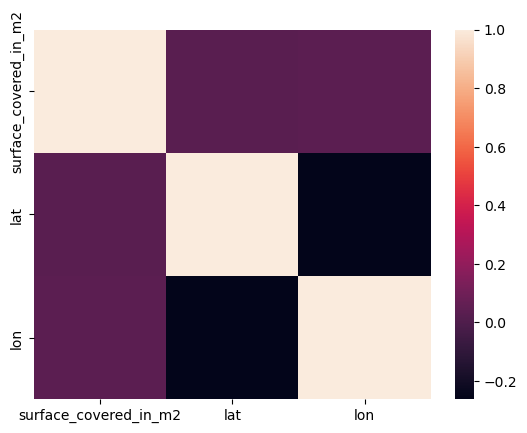

In [96]:
corr = df.select_dtypes("number").drop(columns="price_aprox_usd").corr()
df.info()
sns.heatmap(corr);

## Split

Created feature matrix X_train and target vector y_train.

In [97]:
target = "price_aprox_usd"
feature = ["surface_covered_in_m2", "lat", "lon", "neighborhood"]
y_train = df[target]
X_train = df[feature]


# Building Model

## Baseline

As before I will start with finding the baseline mean absolute error

In [98]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean for i in y_train]

print("Mean apt price:", y_mean)

print("Baseline MAE:", mean_absolute_error(y_train, y_pred_baseline))

Mean apt price: 132383.83701458524
Baseline MAE: 44860.10834274133


## Iterate

I will now create a model that has a `SimpleImputer`, `OneHotEncoder` and `Ridge` linear regression method

In [99]:
model = make_pipeline(OneHotEncoder(sparse_output=False),
                      SimpleImputer(),
                      Ridge()
                     )
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder(sparse_output=False)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

## Evaluate

In [100]:
y_pred_training = model.predict(X_train)
y_pred_training[:5]

array([119980.50270633,  93660.08753989, 158312.90778736,  95854.6628409 ,
        98349.35775921])

In [101]:
print("Training MAE:",mean_absolute_error(y_train, y_pred_training))


Training MAE: 9572.624335506936


# Communicate Results

Here I look at two ways I could deploy my model for stakeholders to use.

First, I will create a function make_prediction that takes four arguments (area, lat, lon, and neighborhood) and returns your model's prediction for an apartment price.

In [78]:
def make_prediction(area, lat, lon, neighborhood):
    data = {
        "surface_covered_in_m2" : area,
        "lat" : lat,
        "lon" : lon,
        "neighborhood" : neighborhood
    }
    df = pd.DataFrame(data, index=[0])
    prediction = model.predict(df).round(2)[0]
    return f"Predicted apartment price: ${prediction}"

In [79]:
make_prediction(110, -34.60, -58.46, "Villa Crespo")

ValueError: Found unknown categories [110] in column 0 during transform